# Recherche de facteurs d'influence sur le temps de sommeil
_Darnatigues Rémy / Guiraud Philippe_

##### Source de la base de données : https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset

L'analyse de cette base de données par régression linéaire va nous permettre de déterminer s'il y a corrélation entre divers facteurs soupçonnés d'influencer le temps de sommeil en se basant sur une étude portant sur 374 personnes en france.

Ces données sont décrites ci-dessous :

#### La variable cible : 
 - Sleep Duration : Temps de sommeil quotidien en heures.

#### Les variables explicatives : 

##### Variables qualitatives :
 - Gender: Genre (M/F).
 - Occupation: Occupation ou métier.
 - BMI Category: L'IMC de la personne sous format texte (e.g., Underweight, Normal, Overweight).
 - Sleep Disorder: Présence ou absence de trouble du sommeil et le trouble en question si présent (insomnie ou apnée du sommeil). (None, Insomnia, Sleep Apnea).

##### Variables quantitatives :
 - Age: Âge en années.
 - Physical Activity Level (minutes/day): Nombre de minutes d'activité physique par jour.
 - Stress Level (scale: 1-10): Note subjective entre 1 et 10 fournie par la personne interrogée sur son niveau de stress.
 - Blood Pressure (systolic/diastolic): Mesure de pression sanguine (en mmHG). 
 - Heart Rate (bpm): Battements cardiaques au repos (en battements/minute).
 - Daily Steps: Nombre de pas journalier.


**Importation du jeu de données :**

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tabulate import tabulate

In [6]:
fichier = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv", sep=",")

**Voici l'entête de notre fichier :**

In [8]:
nb_lignes, nb_colonnes = fichier.shape
display(fichier.head())
print(f"La base initiale contient {nb_lignes} lignes et {nb_colonnes} colonnes.")

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


La base initiale contient 374 lignes et 13 colonnes.


## 1 - Nettoyage des données

Nous laissons de côté la première colonne 'Person ID' car c'est juste un identifiant de compte de personne (de 1 à 374), elle nous sera inutile pour la suite.  
De plus, nous allons séparer la colonne sur la pression sanguine en deux colonnes : une colonne assignée à la pression systolique et une autre à la pression diastolique. 

In [11]:
fichier.drop('Person ID', axis = 1, inplace = True)

# Listes pour stocker les 2 valeurs de Blood Pressure
systolique = []  # valeur 1
diastolique = []  # valeur 2

for value in fichier["Blood Pressure"]:
    val_1, val_2 = value.split('/')
    systolique.append(int(val_1))  
    diastolique.append(int(val_2)) 

fichier['Systolic'] = systolique
fichier['Diastolic'] = diastolique

fichier.drop('Blood Pressure', axis = 1, inplace = True)

In [12]:
nb_lignes, nb_colonnes = fichier.shape
display(fichier.head())

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,NaN,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,NaN,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,NaN,125,80
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


*Remarque : le nombre d'individus et de variables dans notre base ne changent pas suite à cette modification.*

#### On va maintenant vérifier s'il y a des valeurs manquantes dans notre fichier :

In [15]:
valeurs_manquantes = fichier.isnull().sum()
display(pd.DataFrame(valeurs_manquantes, columns=["Nombre de valeurs manquantes"]))

,Nombre de valeurs manquantes
Gender,0
Age,0
Occupation,0
Sleep Duration,0
Quality of Sleep,0
Physical Activity Level,0
Stress Level,0
BMI Category,0
Heart Rate,0
Daily Steps,0


La présence de valeurs manquantes pour la colonne portant sur les troubles du sommeil signifie seulement que la personne n'a pas de trouble.  
Nous remplaçons donc les valeurs "Nan" par "Aucun".

In [17]:
fichier["Sleep Disorder"] = fichier["Sleep Disorder"].fillna("Aucun")
print("Notre nouvelle colonne 'Sleep Disorder' : \n", fichier["Sleep Disorder"])

Notre nouvelle colonne 'Sleep Disorder' : 
 0            Aucun
1            Aucun
2            Aucun
3      Sleep Apnea
4      Sleep Apnea
          ...     
369    Sleep Apnea
370    Sleep Apnea
371    Sleep Apnea
372    Sleep Apnea
373    Sleep Apnea
Name: Sleep Disorder, Length: 374, dtype: object


De plus, en regardant la colonne sur l'IMC :

In [19]:
fichier["BMI Category"].unique()

array(['Overweight', 'Normal', 'Obese', 'Normal Weight'], dtype=object)

On peut remarquer qu'on a deux noms "Normal" et "Normal weight" pour désigner un IMC normal. Nous allons donc remplacer "Normal weight" par "Normal" afin d'homogénéiser le tout.

In [21]:
fichier["BMI Category"] = fichier["BMI Category"].replace({"Normal Weight": "Normal"})

## 2 - Description globale des variables qualitatives

Maintenant que nous nous sommes occupés des valeurs manquantes et autres "anomalies" du fichier, nous allons pouvoir vérifier plus en profondeur nos données. On commence par assigner nos colonnes à des variables python.

In [24]:
# Variables à expliquer Y :
Y = fichier["Sleep Duration"]

# Variables explicatives quantitatives :

genre = fichier["Gender"]
metier = fichier["Occupation"]
IMC = fichier["BMI Category"]
sleepdis = fichier["Sleep Disorder"]

# Variables explicatives quantitatives :
age = fichier["Age"]
activ = fichier["Physical Activity Level"]
battement = fichier["Heart Rate"]
pas = fichier["Daily Steps"]
stress = fichier["Stress Level"]
systolique = fichier["Systolic"]
diastolique = fichier["Diastolic"]

#### Nous allons maintenant afficher effectifs et fréquences pour les variables quantitatives :

In [26]:
table_freq = pd.DataFrame({
    "Effectif": genre.value_counts(),
    "Fréquence (%)": genre.value_counts(normalize=True) * 100
})

print("Tableau des effectifs pour le genre :")
print(tabulate(table_freq, headers="keys", tablefmt="grid"))

Tableau des effectifs pour le genre :
+----------+------------+-----------------+
| Gender   |   Effectif |   Fréquence (%) |
+==========+============+=================+
| Male     |        189 |         50.5348 |
+----------+------------+-----------------+
| Female   |        185 |         49.4652 |
+----------+------------+-----------------+


La proportion homme/femme est parfaitement représentée dans notre base de données. On estime qu'aucun biais ne sera apporté par cette variable.

In [28]:
table_freq = pd.DataFrame({
    "Effectif": metier.value_counts(),
    "Fréquence (%)": metier.value_counts(normalize=True) * 100
})

print("Tableau des effectifs pour les métiers :")
print(tabulate(table_freq, headers="keys", tablefmt="grid"))

Tableau des effectifs pour les métiers :
+----------------------+------------+-----------------+
| Occupation           |   Effectif |   Fréquence (%) |
+======================+============+=================+
| Nurse                |         73 |       19.5187   |
+----------------------+------------+-----------------+
| Doctor               |         71 |       18.984    |
+----------------------+------------+-----------------+
| Engineer             |         63 |       16.8449   |
+----------------------+------------+-----------------+
| Lawyer               |         47 |       12.5668   |
+----------------------+------------+-----------------+
| Teacher              |         40 |       10.6952   |
+----------------------+------------+-----------------+
| Accountant           |         37 |        9.89305  |
+----------------------+------------+-----------------+
| Salesperson          |         32 |        8.55615  |
+----------------------+------------+-----------------+
| Softw

On remarque une grande disparité dans les effectifs de métiers. Il faudra donc chercher à les regrouper, voire accepter de ne pas pouvoir analyser certaines modalités métier.

In [30]:
table_freq = pd.DataFrame({
    "Effectif": IMC.value_counts(),
    "Fréquence (%)": IMC.value_counts(normalize=True) * 100
})

print("Tableau des effectifs pour l'IMC :")
print(tabulate(table_freq, headers="keys", tablefmt="grid"))

Tableau des effectifs pour l'IMC :
+----------------+------------+-----------------+
| BMI Category   |   Effectif |   Fréquence (%) |
+================+============+=================+
| Normal         |        216 |         57.754  |
+----------------+------------+-----------------+
| Overweight     |        148 |         39.5722 |
+----------------+------------+-----------------+
| Obese          |         10 |          2.6738 |
+----------------+------------+-----------------+


Ici on remarque que la modalité "Obese" est très peu représentée. Nous allons vérifier par la suite si les données qui leur sont liées sont similaires à celles de la modalité "Overweight", dans ce cas il sera possible de regouper ces deux modalités en une seule.

In [32]:
table_freq = pd.DataFrame({
    "Effectif": sleepdis.value_counts(),
    "Fréquence (%)": sleepdis.value_counts(normalize=True) * 100
})

print("Tableau des effectifs pour les perturbations du sommeil :")
print(tabulate(table_freq, headers="keys", tablefmt="grid"))

Tableau des effectifs pour les perturbations du sommeil :
+------------------+------------+-----------------+
| Sleep Disorder   |   Effectif |   Fréquence (%) |
+==================+============+=================+
| Aucun            |        219 |         58.5561 |
+------------------+------------+-----------------+
| Sleep Apnea      |         78 |         20.8556 |
+------------------+------------+-----------------+
| Insomnia         |         77 |         20.5882 |
+------------------+------------+-----------------+


Malgré un déséquilibre apparant (60/20/20) des valeurs, on pourra  soit regrouper l'apnée du sommeil avec les insomnies, soit les traiter séparement puisque leurs effectifs sont suffisants.

_faire analyse du regroupement des métiers ici ?_

#### Nous allons maintenant réaliser des tableaux de contingence entre des variables deux à deux.  
##### Elles vont nous permettre de faire ressortir de possibles sur et sous-représentations des effectifs sur les modalités de ces deux variables.

##### 1) Table de contingence : Métier / Genre.

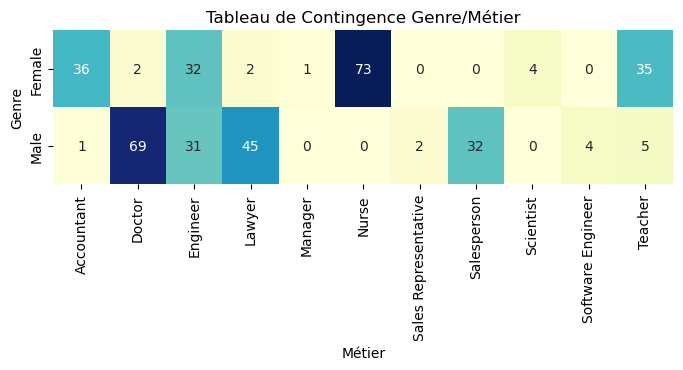

In [37]:
conting_g_m = pd.crosstab(fichier["Gender"], fichier["Occupation"])
plt.figure(figsize=(8, 2))
sns.heatmap(conting_g_m, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Tableau de Contingence Genre/Métier')
plt.xlabel('Métier')
plt.ylabel('Genre')
plt.show()

Nous regardons uniquement les métiers ayant un effectif suffisamment grand.  
Nous remarquons que les femmes représentent la majorité des enseignants, infirmières et comptables.  
Pour leur part, les hommes sont surnuméraires en tant que docteurs, avocats et commerciaux.  
Le seul métier correctement représenté par les deux sexes est celui d'ingénieur.

##### 2) Table de contingence : IMC / Genre

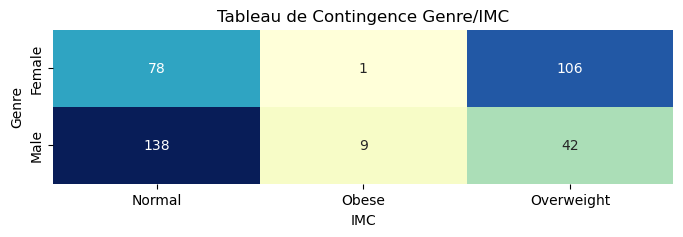

In [40]:
conting_g_m = pd.crosstab(fichier["Gender"], fichier["BMI Category"])
plt.figure(figsize=(8, 2))
sns.heatmap(conting_g_m, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Tableau de Contingence Genre/IMC')
plt.xlabel('IMC')
plt.ylabel('Genre')
plt.show()

Plus surprenant ici, la majorité des personnes en surpoids sont des femmes. On remarque aussi que les femmes sont aussi bien représentées en IMC Normal et Surpoids.  
Les hommes en surpoids sont moins bien représentés que ceux à IMC Normal, nous considérons cependant qu'un effectif de 42 en IMC Surpoids est suffisant pour une analyse ultérieure.

##### 3) Table de contingence : Métier / IMC

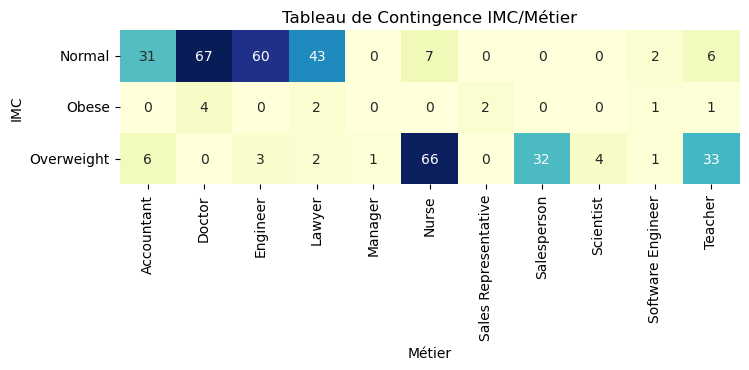

In [43]:
conting_g_m = pd.crosstab(fichier["BMI Category"], fichier["Occupation"])
plt.figure(figsize=(8, 2))
sns.heatmap(conting_g_m, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Tableau de Contingence IMC/Métier')
plt.xlabel('Métier')
plt.ylabel('IMC')
plt.show()

Cette table nous permet de faire le lien avec la précédente afin de déterminer dans quels métiers on retrouve le plus d'hommes et de femmes en surpoids.  
On en ressort les informations suivantes : les infirmières et enseignantes sont principalement des femmes en surpoids alors que les hommes en surpoids sont surtout des commerciaux.

##### 4) Table de contingence : Trouble du sommeil / Genre

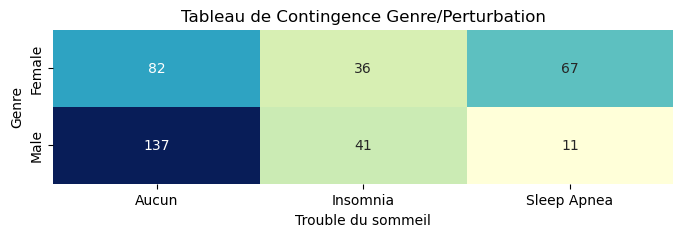

In [46]:
conting_g_m = pd.crosstab(fichier["Gender"], fichier["Sleep Disorder"])
plt.figure(figsize=(8, 2))
sns.heatmap(conting_g_m, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Tableau de Contingence Genre/Perturbation')
plt.xlabel('Trouble du sommeil')
plt.ylabel('Genre')
plt.show()

Les modalités "Aucun trouble" et "Insomnie" ont des effectifs suffisant dans les deux genres.  
En revanche, le trouble de l'apnée du sommeil est largement représentée par les femmes. 

##### 5) Table de contingence : Métier / Trouble du sommeil

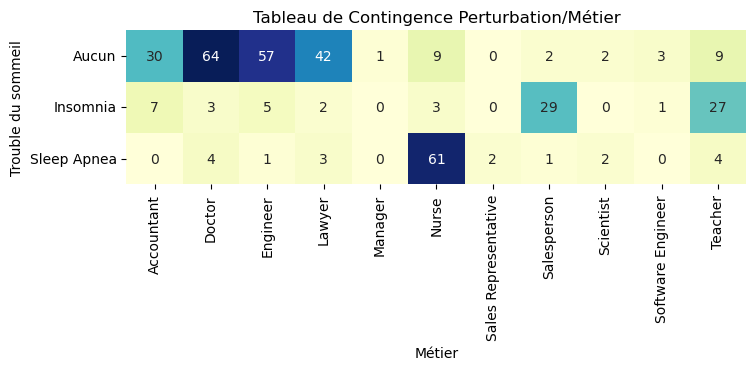

In [49]:
conting_g_m = pd.crosstab(fichier["Sleep Disorder"], fichier["Occupation"])
plt.figure(figsize=(8, 2))
sns.heatmap(conting_g_m, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Tableau de Contingence Perturbation/Métier')
plt.xlabel('Métier')
plt.ylabel('Trouble du sommeil')
plt.show()

Cette table est l'une des plus marquantes car elle montre que métiers et troubles du sommeil sont des variables fortement liés entre elles.

##### 6) Table de contingence Trouble du sommeil / IMC

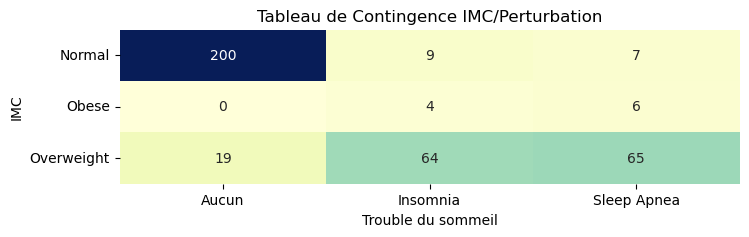

In [52]:
conting_g_m = pd.crosstab(fichier["BMI Category"], fichier["Sleep Disorder"])
plt.figure(figsize=(8, 2))
sns.heatmap(conting_g_m, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Tableau de Contingence IMC/Perturbation')
plt.xlabel('Trouble du sommeil')
plt.ylabel('IMC')
plt.show()

Cette table de contingence sert principalement à confirmer ce que nous pouvions déduire des tables précédentes, à savoir que les personnes en surpoids sont celles souffrant le plus de troubles du sommeil.

##### Dans le prochain notebook, nous réaliserons l'analyse des données quantitatives.
***